In [1]:
import glob
import random

In [2]:
%run 'Text Recognition 1.ipynb'

In [3]:
resnet_digit = ResidualNet(1, 32, 32, 3, 10)
resnet_digit = nn.DataParallel(resnet_digit.cuda())

In [4]:
def split_dataset(dset, batch_size=128, thread_count=8):
    sampler_dset_train = data.sampler.SubsetRandomSampler(list(range(int(0.7*len(dset)))))
    sampler_dset_test = data.sampler.SubsetRandomSampler(list(range(int(0.7*len(dset)), 
                                                                    int(0.85*len(dset)))))
    sampler_dset_validation = data.sampler.SubsetRandomSampler(list(range(int(0.85*len(dset)), 
                                                                          len(dset))))

    loader_dset_train = torch.utils.data.DataLoader(
        dset, batch_size=batch_size, num_workers=thread_count,
        pin_memory=True, sampler = sampler_dset_train)
    loader_dset_test = torch.utils.data.DataLoader(
        dset, batch_size=batch_size, num_workers=thread_count,
        pin_memory=True, sampler = sampler_dset_test)
    loader_dset_validation = torch.utils.data.DataLoader(
        dset, batch_size=batch_size, num_workers=thread_count,
        pin_memory=True, sampler = sampler_dset_validation)

    return loader_dset_train, loader_dset_test, loader_dset_validation

dset_digit = AdvancedImageFolder('by_class', transform, loader = image_loader,
                                 filter_fn = lambda p: p[1] < 10,
                                 shuffle = True)
dset_uppercase_char = AdvancedImageFolder('by_class', transform, target_transform = lambda n: n - 10, 
                                loader = image_loader, filter_fn = lambda p: p[1] >= 10 and p[1] <= 35,
                                shuffle = True)

loader_digit_train, loader_digit_test, loader_digit_validation = split_dataset(dset_digit, thread_count=8, batch_size=128)

In [5]:
def train_model_with_validation(model, train_loader, validation_loader, criterion, 
                                optimizer, lr_scheduler, num_epochs=20):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train(True)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        optimizer = lr_scheduler(optimizer, epoch)

        running_loss = 0.0
        running_corrects = 0

        current_batch = 0
        # Iterate over data.
        for inputs, labels in train_loader:
            current_batch += 1

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), \
                             Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)

            if current_batch % 250 == 0:
                curr_acc = running_corrects / (current_batch * train_loader.batch_size)
                curr_loss = running_loss / (current_batch * train_loader.batch_size)
                time_elapsed = time.time() - since

                print('Epoch Number: {}, Batch Number: {}, Loss: {:.4f}, Acc: {:.4f}'.format(
                        epoch, current_batch, curr_loss, curr_acc))
                print('Time so far is {:.0f}m {:.0f}s'.format(
                      time_elapsed // 60, time_elapsed % 60))

                
        
        validation_acc = test_model(model, validation_loader)
        print('Epoch Number: {}, Validation Accuracy: {:.4f}'.format(epoch, validation_acc))

        # deep copy the model
        if validation_acc > best_acc:
            best_acc = validation_acc
            best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.train(False)
    
    return best_model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_digit = optim.SGD(resnet_digit.parameters(), lr=0.001, momentum=0.9)

In [7]:
resnet_digit = train_model_with_validation(resnet_digit, loader_digit_train, loader_digit_validation, criterion, 
                                           optimizer_digit, exp_lr_scheduler)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 250, Loss: 0.0038, Acc: 0.8706
Time so far is 0m 8s
Epoch Number: 0, Batch Number: 500, Loss: 0.0023, Acc: 0.9223
Time so far is 0m 12s
Epoch Number: 0, Batch Number: 750, Loss: 0.0017, Acc: 0.9420
Time so far is 0m 16s
Epoch Number: 0, Batch Number: 1000, Loss: 0.0014, Acc: 0.9524
Time so far is 0m 20s
Epoch Number: 0, Batch Number: 1250, Loss: 0.0012, Acc: 0.9595
Time so far is 0m 24s
Epoch Number: 0, Batch Number: 1500, Loss: 0.0011, Acc: 0.9644
Time so far is 0m 28s
Epoch Number: 0, Batch Number: 1750, Loss: 0.0010, Acc: 0.9679
Time so far is 0m 32s
Epoch Number: 0, Validation Accuracy: 0.9886

Epoch 1/19
----------
Epoch Number: 1, Batch Number: 250, Loss: 0.0003, Acc: 0.9903
Time so far is 0m 45s
Epoch Number: 1, Batch Number: 500, Loss: 0.0003, Acc: 0.9906
Time so far is 0m 48s
Epoch Number: 1, Batch Number: 750, Loss: 0.0003, Acc: 0.9910
Time so far is 0m 51s
Epoch Number: 1, Batch Number: 1000, Loss: 0.000

Epoch Number: 12, Batch Number: 1000, Loss: 0.0001, Acc: 0.9980
Time so far is 6m 31s
Epoch Number: 12, Batch Number: 1250, Loss: 0.0001, Acc: 0.9980
Time so far is 6m 34s
Epoch Number: 12, Batch Number: 1500, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 38s
Epoch Number: 12, Batch Number: 1750, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 41s
Epoch Number: 12, Validation Accuracy: 0.9948

Epoch 13/19
----------
Epoch Number: 13, Batch Number: 250, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 50s
Epoch Number: 13, Batch Number: 500, Loss: 0.0001, Acc: 0.9980
Time so far is 6m 53s
Epoch Number: 13, Batch Number: 750, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 56s
Epoch Number: 13, Batch Number: 1000, Loss: 0.0001, Acc: 0.9980
Time so far is 6m 60s
Epoch Number: 13, Batch Number: 1250, Loss: 0.0001, Acc: 0.9980
Time so far is 7m 3s
Epoch Number: 13, Batch Number: 1500, Loss: 0.0001, Acc: 0.9979
Time so far is 7m 6s
Epoch Number: 13, Batch Number: 1750, Loss: 0.0001, Acc: 0.9980
Time so far

In [8]:
transform2 = transforms.Compose((transforms.ToTensor(),
                                 transforms.Lambda(tightest_image_crop),
                                 transforms.Lambda(square_padding),
                                 transforms.ToPILImage(),
                                 transforms.Resize(32),
                                 transforms.ToTensor()
                                 ))

In [13]:
digit_image_paths = glob.glob('/media/mehdi2277/MyFiles/large_datasets/text_classification/Debug/cropped_digits/*.png')
random.shuffle(digit_image_paths)

In [10]:
print(len(digit_image_paths))

320722


In [10]:
def show(img):
    npimg = img.numpy()[0]
    plt.figure()
    plt.imshow(npimg, interpolation='nearest', cmap='gray')
    plt.show()

In [11]:
def categoryFromOutput(output):
    _, category_i = output.data.max(0) # Tensor out of Variable with .data
    return category_i

In [14]:
i = 0

with open("predicited_buffalo_digits50k.txt","w") as f:    
    for path in digit_image_paths:
        img = transform2(image_loader(path))
        log_probs = resnet_digit(Variable(img).unsqueeze(0).cuda()).squeeze()
        _, category = log_probs.data.max(0)
        
        f.write("%s %d\n" % (path.split('/')[-1], category[0]))
        
        i += 1
        
        if i % 5000 == 0:
            print(i)
        
        if i == 50000:
            break

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


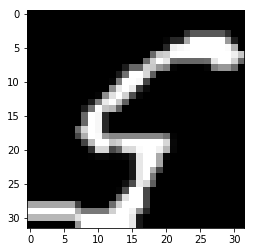

5


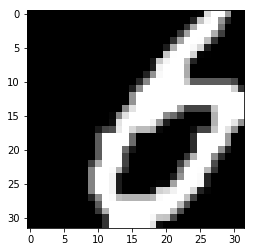

5


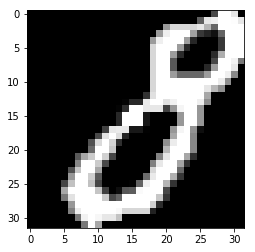

8


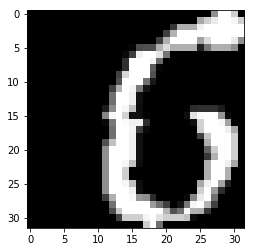

6


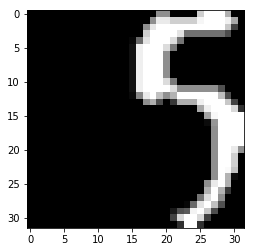

5


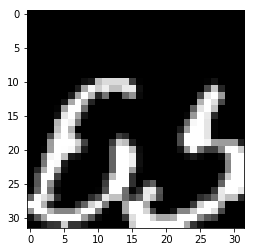

6


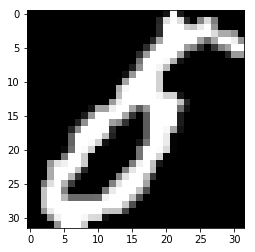

5


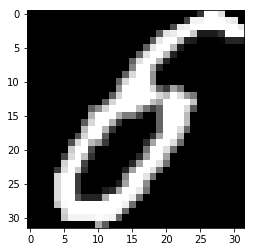

5


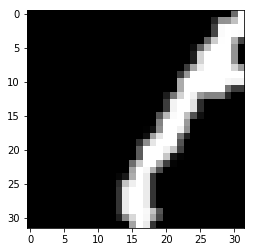

1


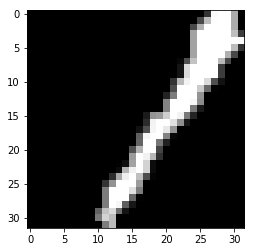

1


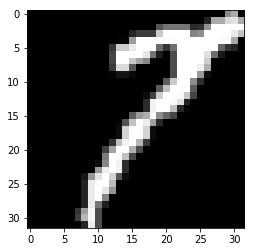

7


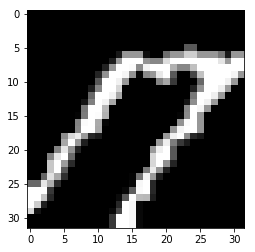

8


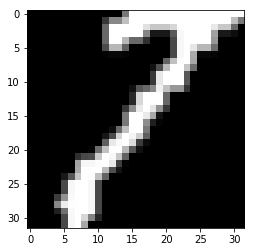

7


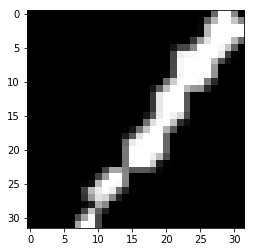

4


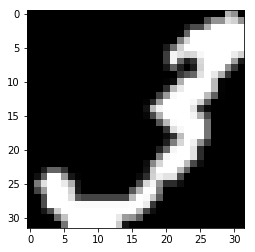

3


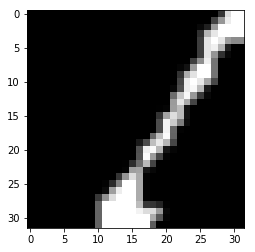

2


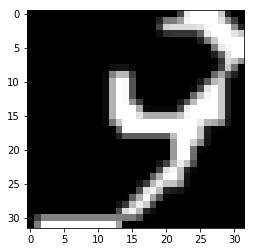

9


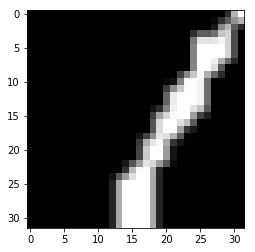

2


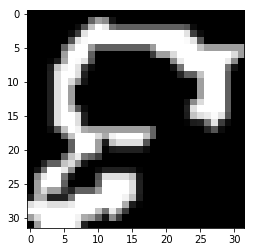

8


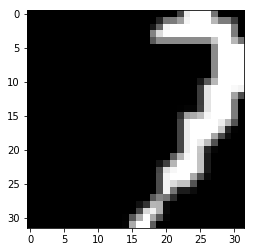

7


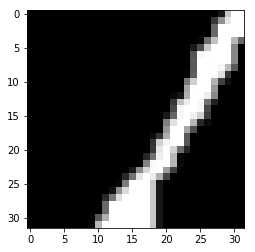

2


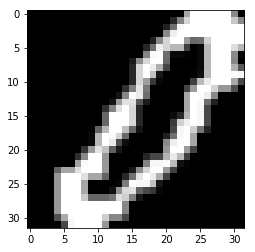

0


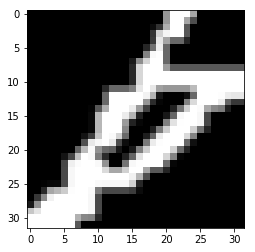

8


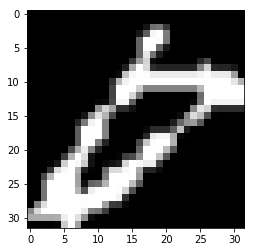

8


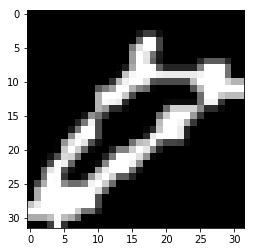

8


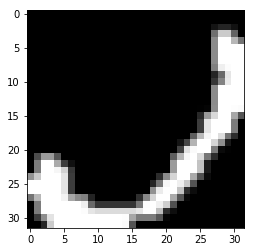

2


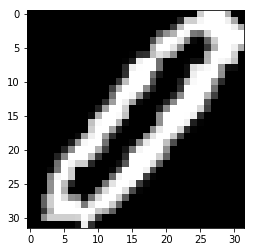

0


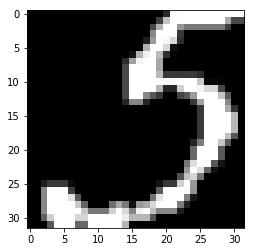

5


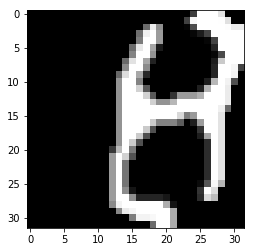

8


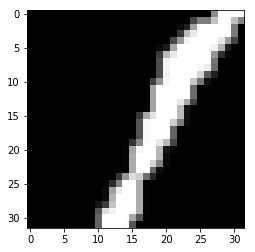

1


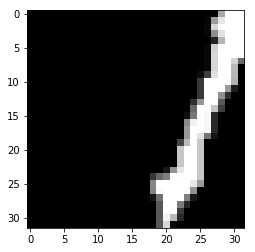

1


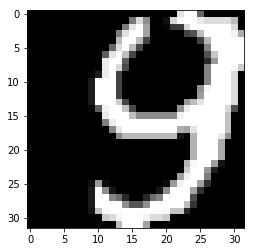

9


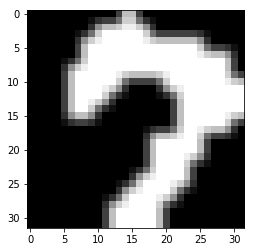

7


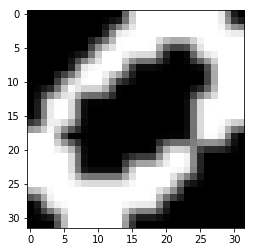

0


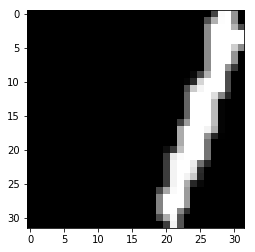

1


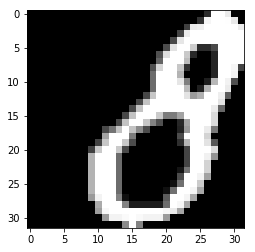

8


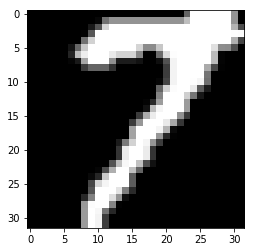

7


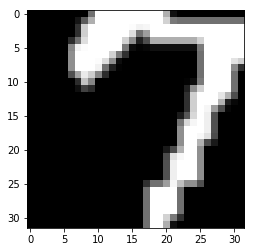

7


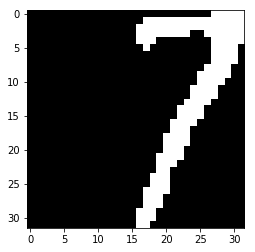

7


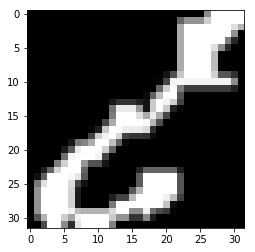

2


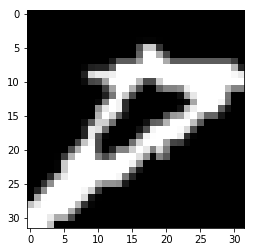

8


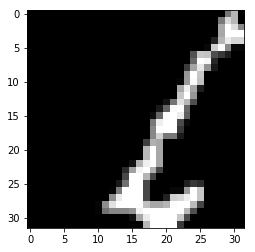

2


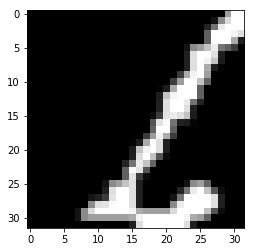

2


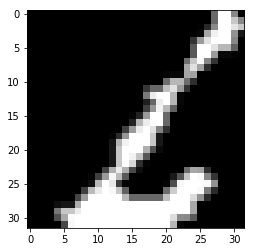

6


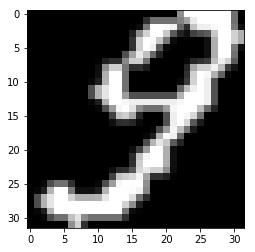

9


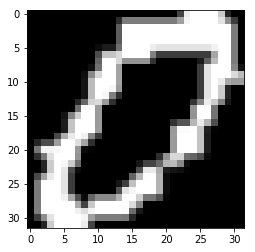

0


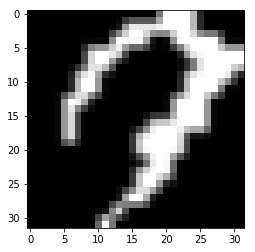

7


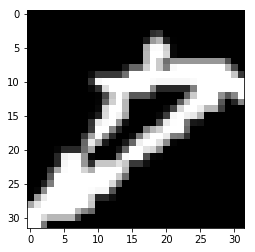

8


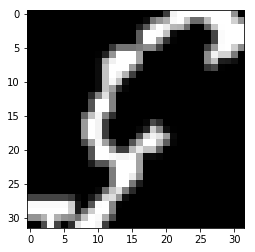

5


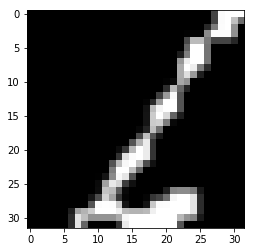

2


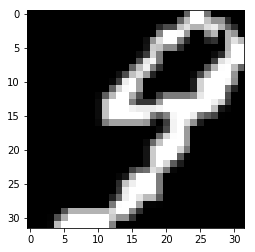

9


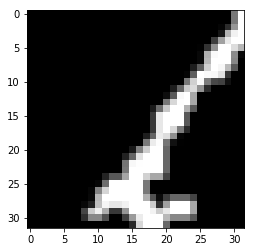

2


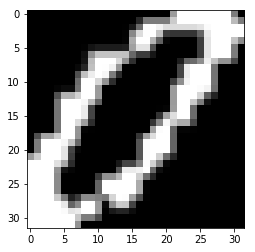

0


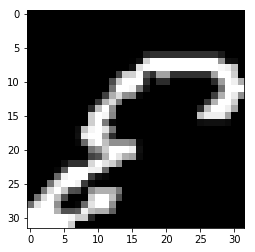

8


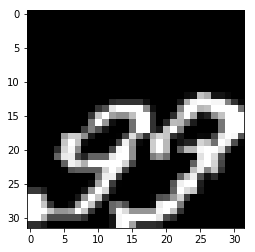

6


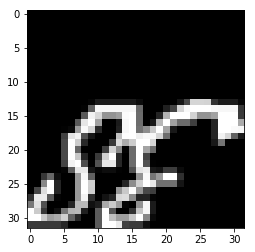

6


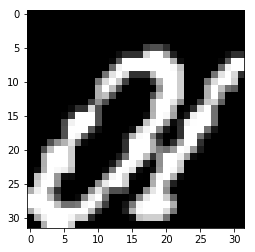

0


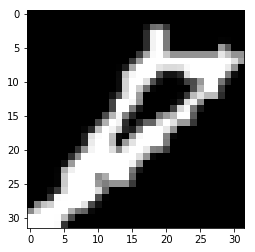

8


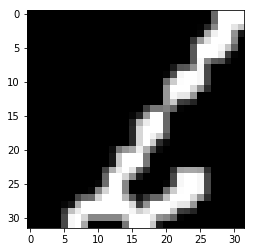

6


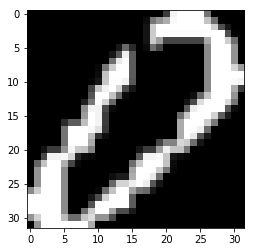

0


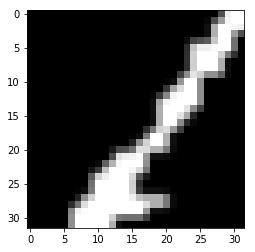

2


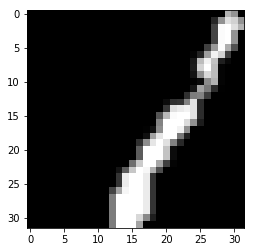

2


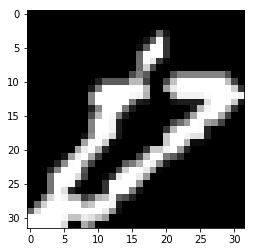

8


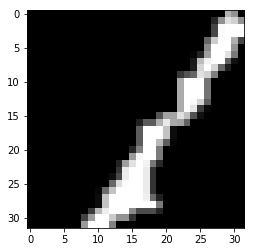

2


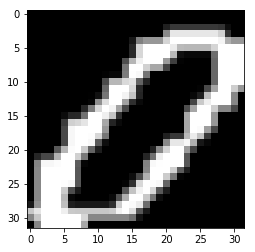

0


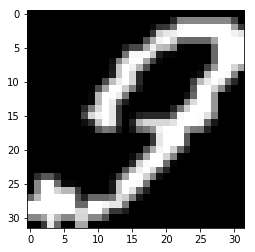

9


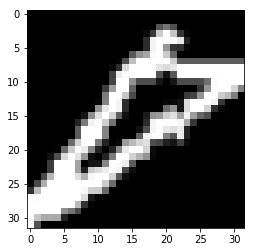

8


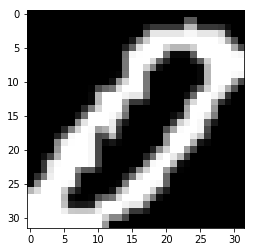

0


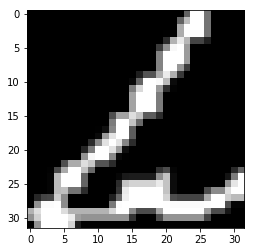

2


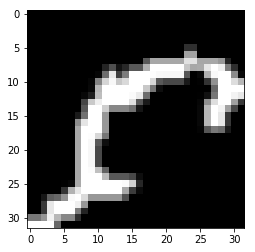

0


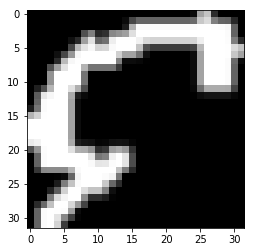

9


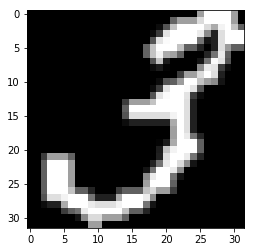

3


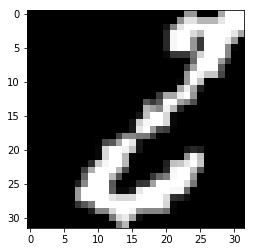

2


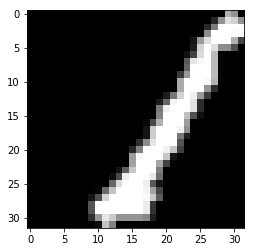

2


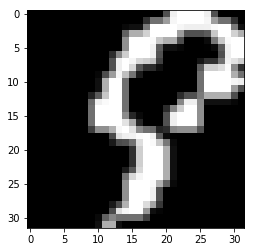

9


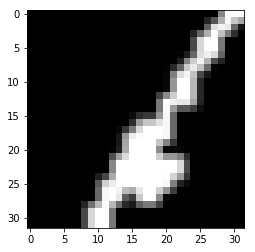

6


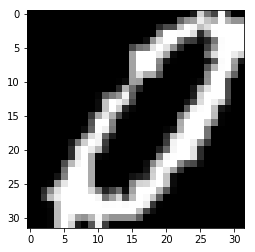

0


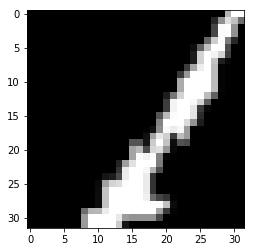

2


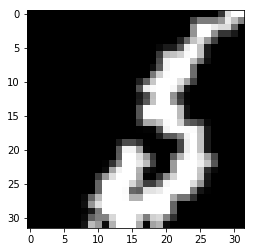

5


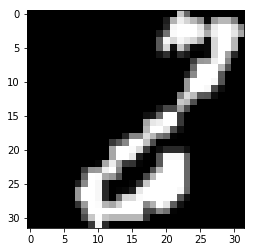

2


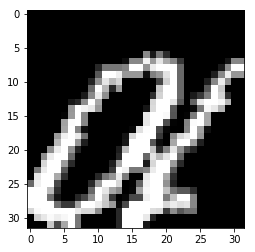

0


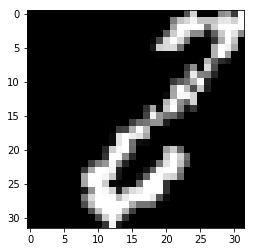

2


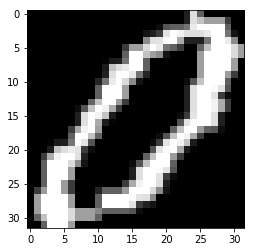

0


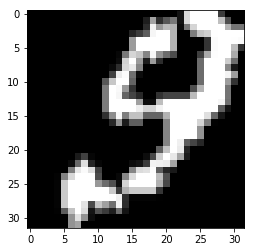

9


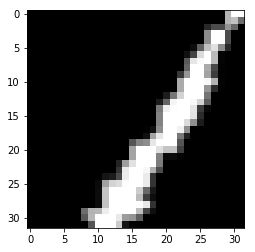

2


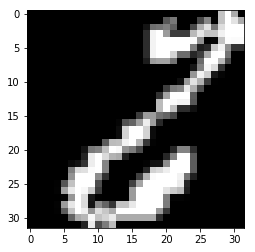

2


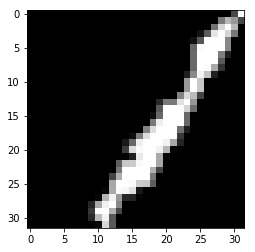

2


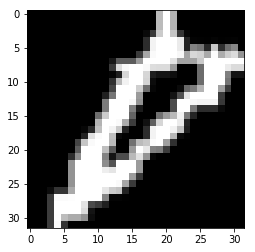

8


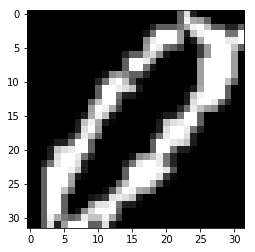

0


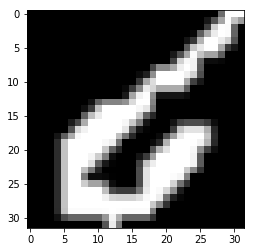

6


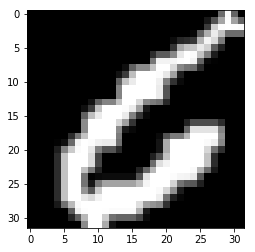

6


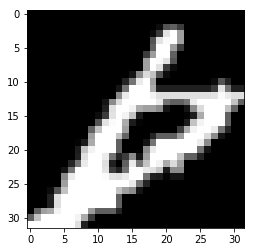

0


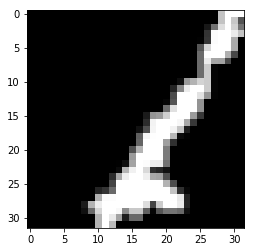

2


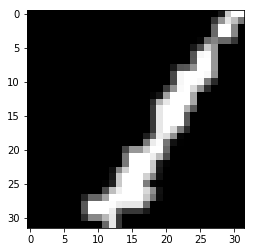

2


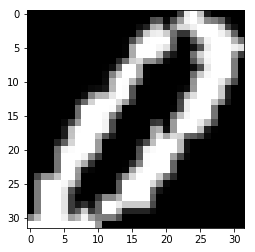

8


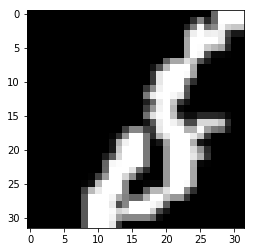

6


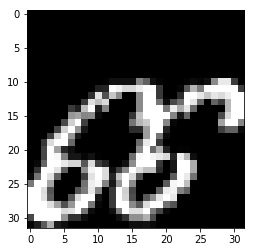

0


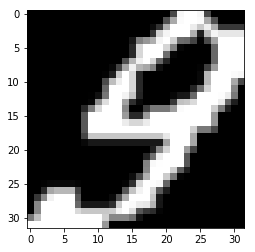

9


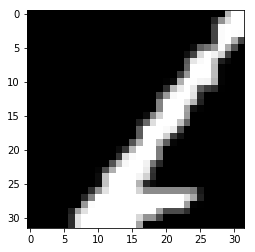

2


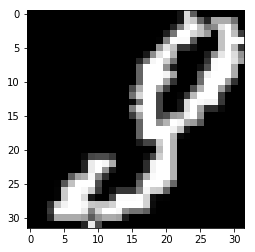

3


In [12]:
i = 0

for path in digit_image_paths:
        img = transform2(image_loader(path))
        log_probs = resnet_digit(Variable(img).unsqueeze(0).cuda()).squeeze()
        _, category = log_probs.data.max(0)
        
        show(img)
        print(category[0])
        
        i += 1
        
        if i == 50000:
            break